In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using Theano backend.


In [2]:
# Load the data in from the serialized array
data = np.load(file='font_arr.npy')

# Separate the data into test and training tests
x_train = data[:len(data) * 0.8]
x_test = data[len(data) * 0.8:]

/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [3]:
# Noisify the training images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# Ensure that the values of the noisy arrays contain pixels with values between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

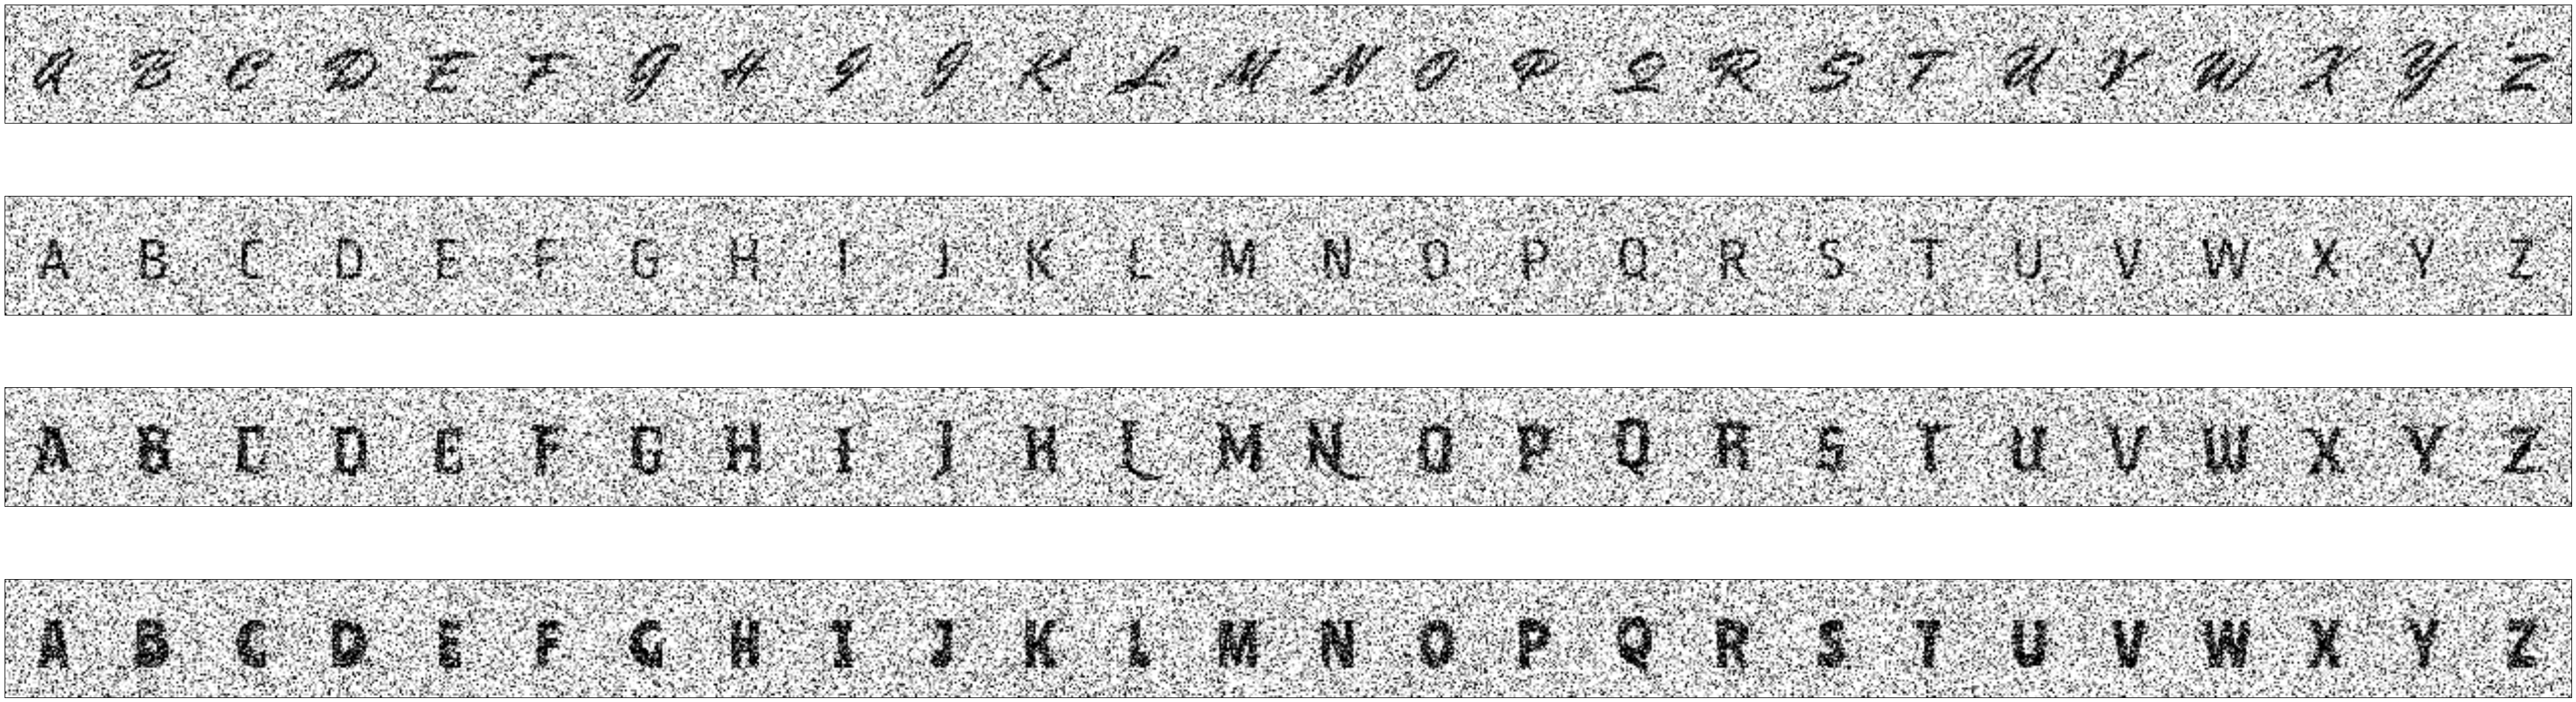

In [4]:
# Display n amount of the noisy training samples
n = 4
plt.figure(figsize=(70, 20))
for i in range(1,n+1):
    ax = plt.subplot(n, 1, i)
    plt.imshow(x_test_noisy[i].reshape(60, 1300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
# Runs 32 different kernels through the image
num_filters = 32

# 3x3 kernel size
kernel_x = 3
kernel_y = kernel_x

# Downscale the image by a factor of 2 each pooling layer
pooling_factors = (2,2)

In [6]:
input_img = Input(shape=(1, 60, 1300), name='Input image')

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #1')(input_img)
x = MaxPooling2D(pooling_factors, border_mode='same', name='Pooling layer #1')(x)
x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #2')(x)
encoded = MaxPooling2D(pooling_factors, border_mode='same', name='Encoding pooling layer')(x)

# at this point the representation is (32, 7, 7)
# EACH FILTER ADDS A DIMENSION!!!!

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #1')(encoded)
x = UpSampling2D(pooling_factors, name='Upsampling layer #1')(x)
x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #2')(x)
x = UpSampling2D(pooling_factors, name='Upsampling layer #2')(x)
decoded = Convolution2D(1, kernel_x, kernel_y, activation='sigmoid', border_mode='same', name='Piece-together conv layer')(x)
# THE NUMBER OF KERNELS HERE IS 1 BECAUSE THAT WAY IT OUTPUTS A SINGLE DIMENSION (CHANNEL)

# Compiles the model diagram described above into a neural network
autoencoder = Model(input=input_img, output=decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [49]:
# How many training cycles the program does
num_epoch = 3

# How many images to process before backpropagating
batch_size = 10

In [53]:
print(batch_size)
train = autoencoder.fit(x_train_noisy, x_train,
                nb_epoch=num_epoch,
                batch_size=batch_size,
                validation_data=(x_test_noisy, x_test))


10
Train on 616 samples, validate on 154 samples
Epoch 1/1
616/616 [==============================] - 282s - loss: 0.0426 - val_loss: 0.0424


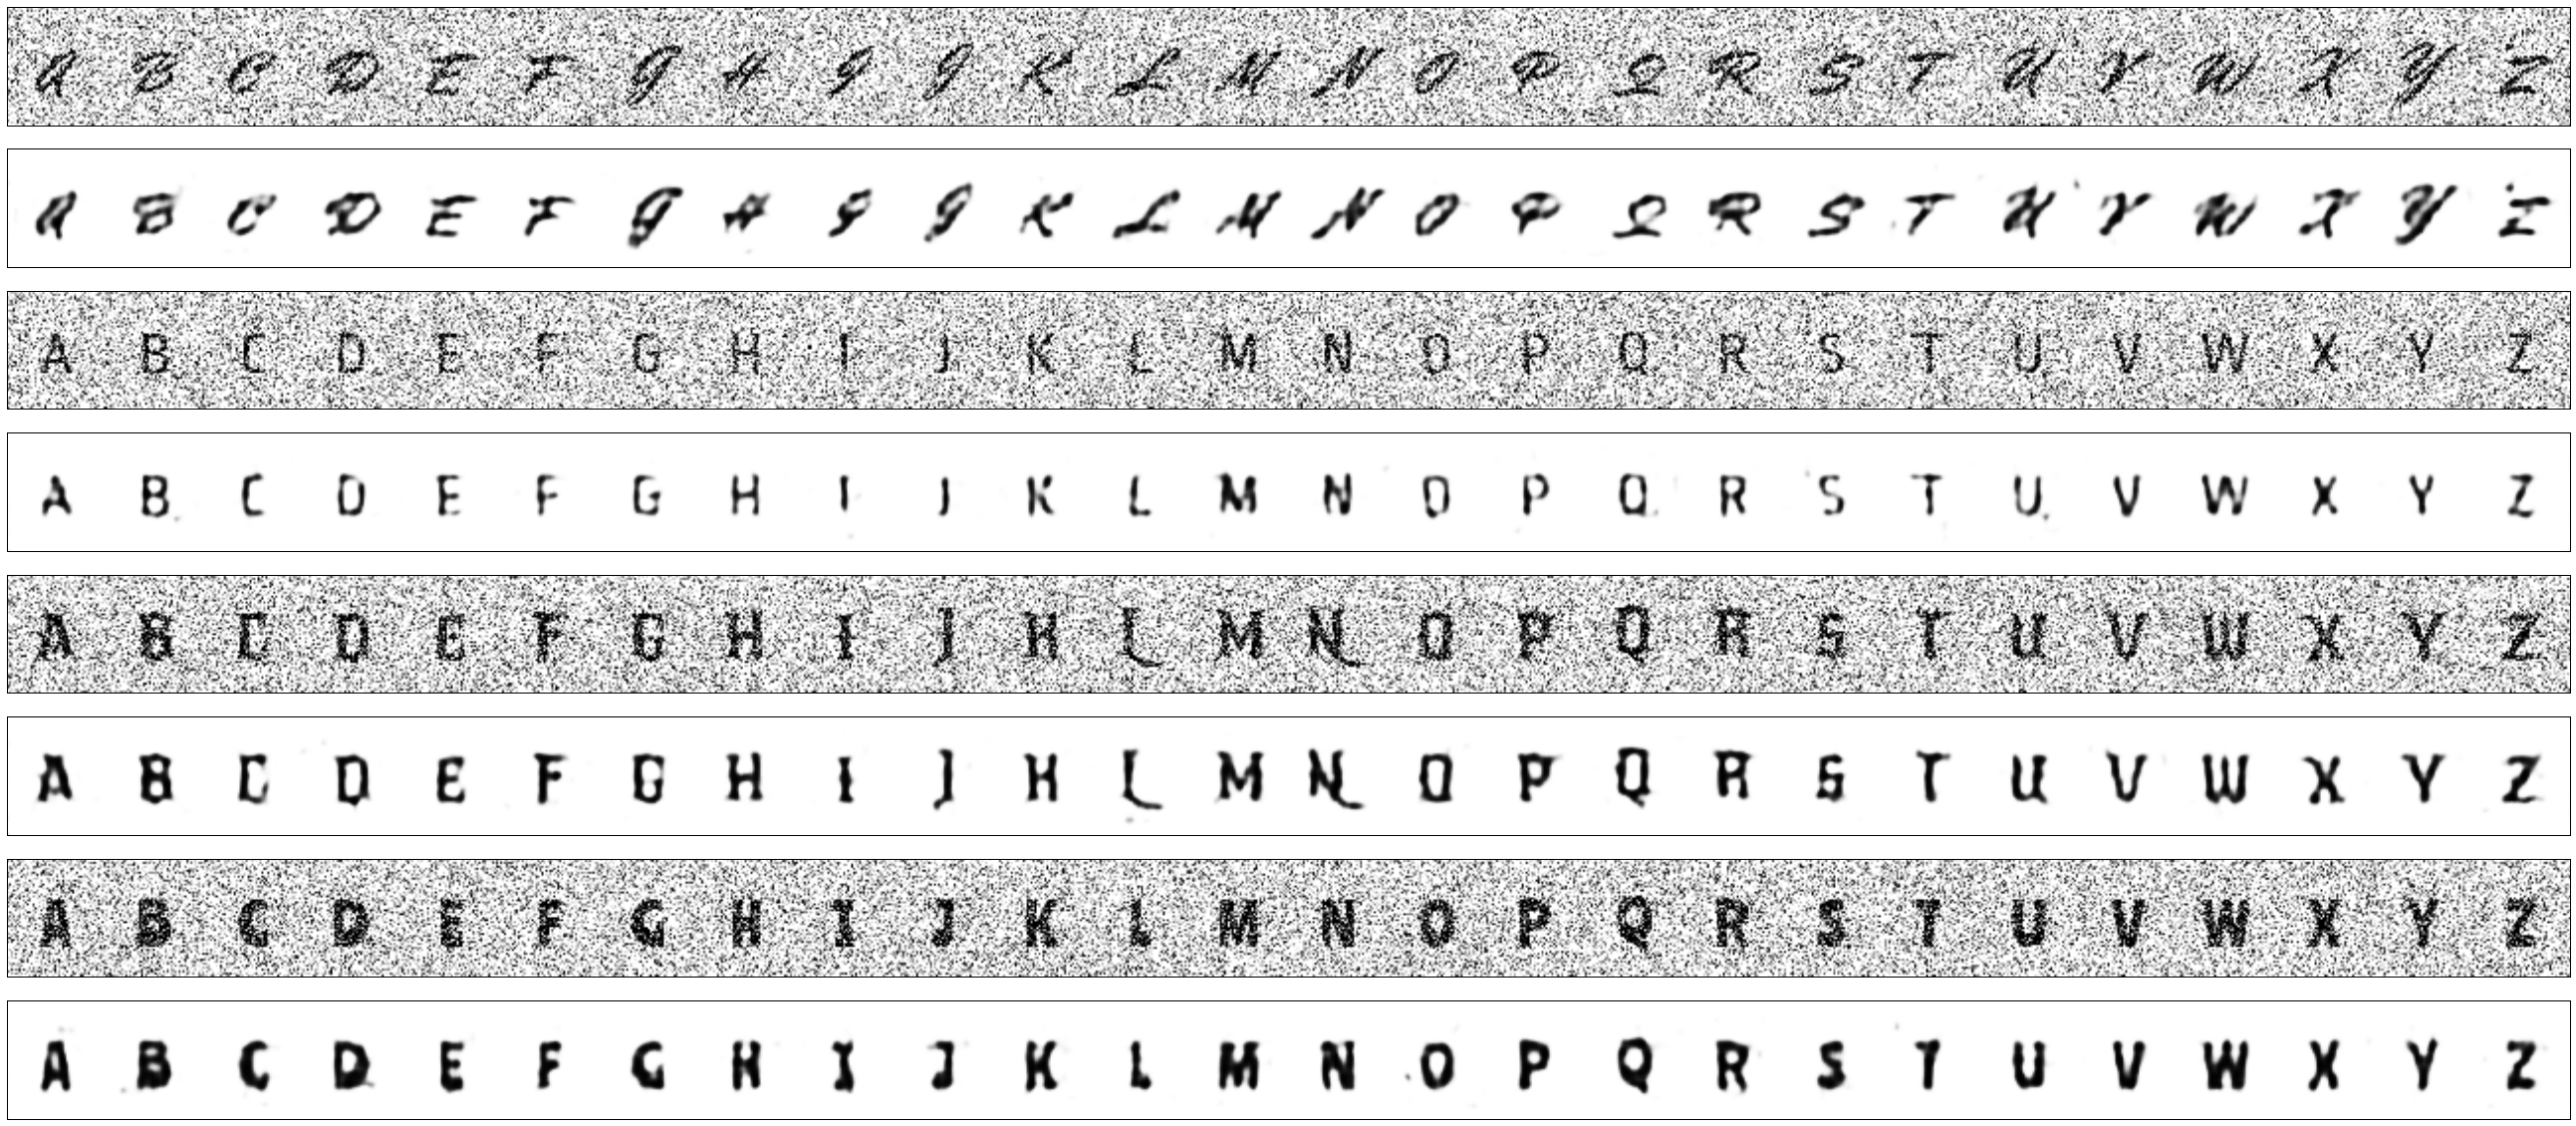

In [51]:
n = 4
decoded_imgs = autoencoder.predict(x_test_noisy[:n+1])

plt.figure(figsize=(70, 20))
cnt = 1
for i in range(1,n+1):
    # display original
    ax = plt.subplot(n*2, 1, cnt)
    plt.imshow(x_test_noisy[i].reshape(60, 1300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    cnt+=1
    ax = plt.subplot(n*2, 1, cnt)
    plt.imshow(decoded_imgs[i].reshape(60, 1300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1
plt.show()

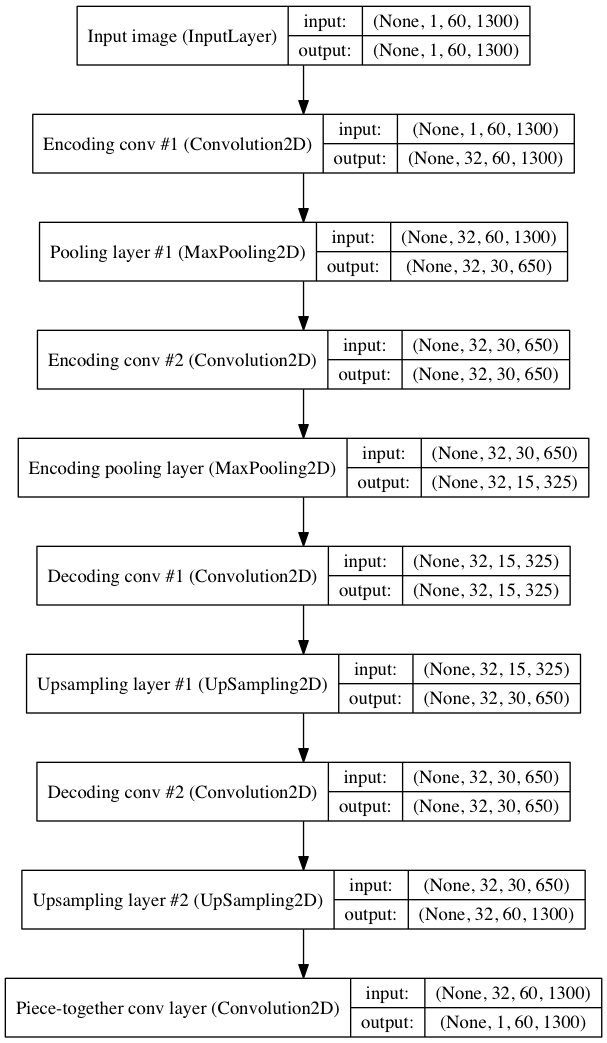

In [25]:
from IPython.display import SVG, Image
from keras.utils.visualize_util import model_to_dot, plot

# SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))
plot(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename="autoencoder.png")

In [ ]:
np